# <b>Restaurant Revenue Prediction</b>

## 1. Import Libraries

In [2]:
import os
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

### 1-1. Fixed Seed

In [3]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## 2. Load Data
`train.csv`: 학습 데이터, 타겟: revenue<br>
`test.csv`: 테스트 데이터 <br>

In [4]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')

In [5]:
train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [6]:
test.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,2.0,3.0,0,4,0,0,0,0,0,0
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,5.0,3.0,0,0,0,0,0,0,0,0


### 2-1. 데이터 설명

In [7]:
def data_describe(df, title):
    print(f'====================== {title} Data Describe ======================')
    print(f'Row: {df.shape[0]}, Column: {df.shape[1]}')
    columns = df.columns
    data_type = []

    for col in columns:
        data_type.append(df[col].dtype)

    n_uniq = df.nunique()
    n_miss = df.isna().sum()

    names = list(zip(columns, data_type, n_uniq, n_miss))
    variable_desc = pd.DataFrame(names, columns=['Column', 'Dtype', 'Unique levels', 'Missing Count'])
    print(variable_desc)

In [8]:
data_describe(train, 'Train')

====================== Train Data Describe ======================
Row: 137, Column: 43
        Column    Dtype  Unique levels  Missing Count
0           Id    int64            137              0
1    Open Date   object            134              0
2         City   object             34              0
3   City Group   object              2              0
4         Type   object              3              0
5           P1    int64              8              0
6           P2  float64              8              0
7           P3  float64              8              0
8           P4  float64              6              0
9           P5    int64              7              0
10          P6    int64              8              0
11          P7    int64              6              0
12          P8    int64              8              0
13          P9    int64              4              0
14         P10    int64              4              0
15         P11    int64              8           

In [9]:
data_describe(test, 'Test')

====================== Test Data Describe ======================
Row: 100000, Column: 42
        Column    Dtype  Unique levels  Missing Count
0           Id    int64         100000              0
1    Open Date   object            310              0
2         City   object             57              0
3   City Group   object              2              0
4         Type   object              4              0
5           P1    int64              9              0
6           P2  float64              9              0
7           P3  float64              7              0
8           P4  float64              7              0
9           P5    int64              6              0
10          P6    int64              8              0
11          P7    int64              7              0
12          P8    int64              8              0
13          P9    int64              5              0
14         P10    int64              4              0
15         P11    int64              8         

## 3. EDA

### 3-1. Target Distribution

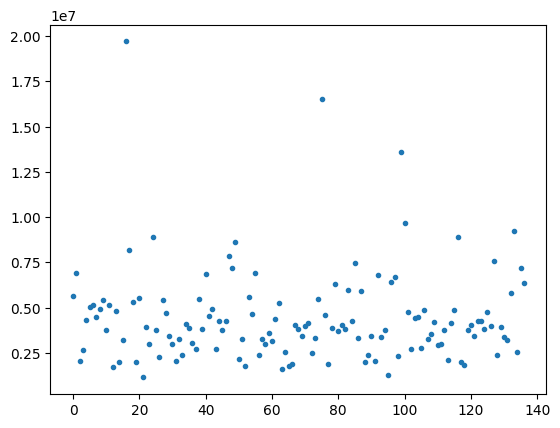

In [10]:
plt.plot(train['revenue'], '.')
plt.show()

- 이상치 제거

In [11]:
# 이상치 제거
train = train[~train['revenue'].ge(1.25 * 10**7)].copy()
train = train.reset_index(drop=True)

In [12]:
cat_feature = [col for col in train.columns if train[col].dtypes=='O']
print('범주형 변수:', cat_feature)

범주형 변수: ['Open Date', 'City', 'City Group', 'Type']


In [13]:
num_feature = [col for col in train.columns if train[col].dtypes!='O']
print('수치형 변수:', num_feature)

수치형 변수: ['Id', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'revenue']


## 4. Preprocessing

In [14]:
def fe(df):
    df['Date'] = pd.to_datetime(df['Open Date'], format="%m/%d/%Y")
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Years_Old'] = pd.to_datetime('2015-03-23').year - df['Date'].dt.year

    df = df.drop(['Open Date', 'Date'],axis=1)

    return df

In [15]:
train = fe(train)
test = fe(test)

In [16]:
train.head()

,Id,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,P33,P34,P35,P36,P37,revenue,Year,Month,Day,Years_Old
0,0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,...,5,5,4,3,4,5653753.0,1999,7,17,16
1,1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,...,0,0,0,0,0,6923131.0,2008,2,14,7
2,2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,...,0,0,0,0,0,2055379.0,2013,3,9,2
3,3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,...,6,18,12,12,6,2675511.0,2012,2,2,3
4,4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,...,2,3,4,3,3,4316715.0,2009,5,9,6


In [17]:
test.head()

,Id,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,P32,P33,P34,P35,P36,P37,Year,Month,Day,Years_Old
0,0,Niğde,Other,FC,1,4.0,4.0,4.0,1,2,...,0,0,0,0,0,0,2011,1,22,4
1,1,Konya,Other,IL,3,4.0,4.0,4.0,2,2,...,0,0,0,0,0,0,2011,3,18,4
2,2,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,2,...,0,0,0,0,0,0,2013,10,30,2
3,3,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,3,...,0,0,0,0,0,0,2013,5,6,2
4,4,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,2,...,0,0,0,0,0,0,2013,7,31,2


In [18]:
train_x = train.drop(['Id', 'revenue'], axis=1)
train_y = train['revenue']

test_x = test.drop(['Id'], axis=1)

In [19]:
for feature in ['City', 'City Group', 'Type']:
    le = LabelEncoder()
    le = le.fit(train_x[feature])
    train_x[feature] = le.transform(train_x[feature])

    for label in np.unique(test_x[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test_x[feature] = le.transform(test_x[feature])

In [20]:
train_x.head()

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,P32,P33,P34,P35,P36,P37,Year,Month,Day,Years_Old
0,31,0,2,4,5.0,4.0,4.0,2,2,5,...,4,5,5,4,3,4,1999,7,17,16
1,3,0,1,4,5.0,4.0,4.0,1,2,5,...,0,0,0,0,0,0,2008,2,14,7
2,10,1,2,2,4.0,2.0,5.0,2,3,5,...,0,0,0,0,0,0,2013,3,9,2
3,28,1,2,6,4.5,6.0,6.0,4,4,10,...,10,6,18,12,12,6,2012,2,2,3
4,14,1,2,3,4.0,3.0,4.0,2,2,5,...,3,2,3,4,3,3,2009,5,9,6


In [21]:
test_x.head()

,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,...,P32,P33,P34,P35,P36,P37,Year,Month,Day,Years_Old
0,52,1,1,1,4.0,4.0,4.0,1,2,5,...,0,0,0,0,0,0,2011,1,22,4
1,20,1,2,3,4.0,4.0,4.0,2,2,5,...,0,0,0,0,0,0,2011,3,18,4
2,3,0,1,3,4.0,4.0,4.0,2,2,5,...,0,0,0,0,0,0,2013,10,30,2
3,19,1,2,2,4.0,4.0,4.0,2,3,5,...,0,0,0,0,0,0,2013,5,6,2
4,1,1,1,2,4.0,4.0,4.0,1,2,5,...,0,0,0,0,0,0,2013,7,31,2


In [22]:
scaler = StandardScaler()
train_x_scale = scaler.fit_transform(train_x)
test_x_scale = scaler.transform(test_x)

In [23]:
print(train_x_scale.shape, train_y.shape)

(134, 44) (134,)


## 5. Train Model
- 평가지표: `Root Mean Squared Error(RMSE)`

In [24]:
rf_model = RandomForestRegressor(max_depth=7,
                                 max_features='sqrt',
                                 min_samples_split=0.12,
                                 n_estimators=120)

rf_model.fit(train_x_scale, train_y)

RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_split=0.12,
                      n_estimators=120)

## 6. Submission

In [25]:
submission = pd.read_csv('sampleSubmission.csv')

In [26]:
y_pred = rf_model.predict(test_x_scale)

In [27]:
submission['Prediction'] = y_pred
submission.head()

,Id,Prediction
0,0,4.579132e+06
1,1,3.655684e+06
2,2,3.571649e+06
3,3,3.258669e+06
4,4,3.636570e+06


In [28]:
submission.to_csv('submission.csv', index=False)